# Multi Objective Optimization of Polymers for Strength and Biodegradability

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sgbaird/honegumi/blob/main/docs/curriculum/tutorials/mobo/mobo-tutorial.ipynb)

In [1]:
try:
    import google.colab
    %pip install ax-platform
except:
    print("Not running in Google Colab")

Not running in Google Colab




Imagine you work at a custom materials solutions company that specializes in creating polymer compounds for various applications. A customer has requested a polymer formulation with high strength and a high biodegradability score. The customer is unsure of the tradeoff between the two properties but knows that the target application will require a strength of at least 70 MPa. As the customer is concerned about the toxicitiy and biodegradability of the polymer, they have limited you to a set of **five** thermoplastic monomers that can be used in the formulation.

You believe Bayesian optimization can help you in this task and decide to put together an optimization script using Honegumi to help solve this problem.

Taking note of available composition and process parameters you decide to restrict your design space to the following:

| | **Parameter Name** | **Bounds**  |
|------|--------------------|-------------|
| x1   | Monomer A          | [0, 1]       |
| x2   | Monomer B          | [0, 1]       |
| x3   | Monomer C          | [0, 1]       |
| x4   | Monomer D          | [0, 1]       |
| x5   | Monomer E          | [0, 1]       |
| x6   | Extrusion Rate     | [0.01, 0.1] |
| x7   | Temperature        | [120, 200]  |

To help find a solution quickly, you dig up some data on these polymer systems in the literature and decide to use them to help improve the surrogate model. While none of these meet the customer requirement, you think they might at least help tell your model where NOT to look. The collected data is as follows:

| **x1** | **x2** | **x3** | **x4** | **x5** | **x6** | **x7** | **Strength** | **BioDeg** |
|--------|--------|--------|--------|--------|--------|--------|--------------|------------|
| 0.3    | 0.2    | 0.1    | 0.0    | 0.4    | 0.05   | 150    | 43.73        | 1.81       |
| 0.0    | 0.0    | 0.3    | 0.7    | 0.0    | 0.1    | 160    | 25.79        | 3.83       |
| 0.2    | 0.2    | 0.2    | 0.2    | 0.2    | 0.09   | 184    | 41.37        | 2.29       |

A dummy objective function that returns outputs for each property has been constructed in the code cell below. This functions aims to emulate the results of experimental trials under different inputs. Although we can easily find optimal values using the equations, we will pretend that the objective function is unknown and use a Bayesian optimization approach to find the optimal set of input parameters instead.

In [1]:
import numpy as np

def measure_properties(x1, x2, x3, x4, x5, x6, x7):
    """
    Calculates the strength and biodegradability properties of a polymer based 
    on a set of given input parameters.

    Parameters:
    x1 (float): volume fraction of monomer 1. Range: [0.0, 1.0].
    x2 (float): volume fraction of monomer 2: [0.0, 1.0].
    x3 (float): volume fraction of monomer 3: [0.0, 1.0].
    x4 (float): volume fraction of monomer 4: [0.0, 1.0].
    x5 (float): volume fraction of monomer 5: [0.0, 1.0].
    x6 (float): the polymer extrusion rate. Range: [0.01, 0.1].
    x7 (float): the processsing temperature. Range: [120.0, 200.0].

    Returns:
    dict: calculated strength and biodegradability properties of polymer in form:
          {
              "strength": float,
              "biodegradability": float
          }
    """
    strength = float(
        np.exp(-(50*(x1-0.5)**2)) +
        np.exp(-(5*(x2-0.4)**2)) -
        0.8*x3 +
        np.exp(-(300*(x4-0.1)**2)) -
        0.3*x5**2 +
        np.exp(-(2000*(x6-0.025)**2)) +
        1/(1+np.exp(-(x7-137)/15))
    )

    biodegradability = float(
        -1/(1+np.exp(-(x1-0.1)/0.1)) + 1 +
        -1/(1+np.exp(-(x2-0.3)/0.1)) + 1 +
        x3**2 +
        x4 +
        1/(1+np.exp(-(x5-0.7)/0.075)) +
        10*x6 +
        -(x7/200)**2+1
    )

    return {"strength" : strength*25, "biodegradability" : biodegradability*5}

## Applying Honegumi

We will now use the [Honegumi website](https://honegumi.readthedocs.io/en/latest/) to generate a script that will help us optimize the polymer parameters. From the description, we observe that our problem is a **multi objective** optimization problem with a **constraint on the fractional sum of monomer components** and a **custom threshold** on the optimized strength. Additionally, we would like to include some **historical data** in our model training. To create an optimization script for this problem, we select the following options:

![Honegumi Selections for Multi Objective Optimization](multi_objective_selection.png)

The Honegumi generated optimization script will provide a framework for our optimization campaign that we can modify to suit our specific problem needs. In the code sections below, we will make several modifications to this generated script to make it compatible with our problem.

## Modifying the Code for Our Problem

We can modify this code to suit our problem with a few simple modifications. Wherever a modification has been made to the code, a comment starting with `# MOD:` has been added along with a brief description of the change.

In [ ]:
import numpy as np
import pandas as pd
from ax.service.ax_client import AxClient, ObjectiveProperties
import matplotlib.pyplot as plt

obj1_name = "strength" # MOD: change first objective name
obj2_name = "biodegradability" # MOD: change second objective name

# MOD: remove the moo_branin dummy objective function, we will use the polymer function

total = 1.0 # MOD: update total quantity for the composition constraint

# MOD: add the historical data that was pulled from the literature
X_train = pd.DataFrame(
    [
        {"x1": 0.3, "x2": 0.2, "x3": 0.1, "x4": 0.0, "x5": 0.4, "x6": 0.05, "x7": 150.0},
        {"x1": 0.0, "x2": 0.0, "x3": 0.3, "x4": 0.7, "x5": 0.0, "x6": 0.1, "x7": 160.0},
        {"x1": 0.2, "x2": 0.2, "x3": 0.2, "x4": 0.2, "x5": 0.2, "x6": 0.09, "x7": 184.0},
    ]
)

# MOD: calculate the y_train values using the measure_properties function
y_train = [measure_properties(**row[1]) for row in X_train.iterrows()]

# Define the number of training examples
n_train = len(X_train)

ax_client = AxClient(random_seed=12345) # MOD: add random seed for reproducibility

ax_client.create_experiment(
    parameters=[
        {"name": "x1", "type": "range", "bounds": [0.0, 1.0]}, # MOD: update param
        {"name": "x2", "type": "range", "bounds": [0.0, 1.0]}, # MOD: update param
        {"name": "x3", "type": "range", "bounds": [0.0, 1.0]}, # MOD: add new param
        {"name": "x4", "type": "range", "bounds": [0.0, 1.0]}, # MOD: add new param
        {"name": "x6", "type": "range", "bounds": [0.01, 0.1]}, # MOD: add new param
        {"name": "x7", "type": "range", "bounds": [120.0, 200.0]}, # MOD: add new param
    ], # NOTE: x5 has been "hidden" from the search space
    objectives={ # MOD: set minimize=False and add threshold values
        obj1_name: ObjectiveProperties(minimize=False, threshold=70.0),
        obj2_name: ObjectiveProperties(minimize=False, threshold=0.0),
    },
    parameter_constraints=[
        f"x1 + x2 + x3 + x4 <= {total}", # MOD: update composition constraint
    ],
)

# Add existing data to the AxClient
for i in range(n_train):
    parameterization = X_train.iloc[i].to_dict()

    # remove x5, since it's hidden from search space due to composition constraint
    parameterization.pop("x5")

    ax_client.attach_trial(parameterization)
    ax_client.complete_trial(trial_index=i, raw_data=y_train[i])


for _ in range(35): # MOD: increase number of trials

    parameterization, trial_index = ax_client.get_next_trial()

    # MOD: pull all added parameters from the parameterization
    x1 = parameterization["x1"]
    x2 = parameterization["x2"]
    x3 = parameterization["x3"]
    x4 = parameterization["x4"]
    x5 = total - (x1 + x2 + x3 + x4) # MOD: update composition constraint
    x6 = parameterization["x6"]
    x7 = parameterization["x7"]

    results = measure_properties(x1, x2, x3, x4, x5, x6, x7) # MOD: use polymer function
    ax_client.complete_trial(trial_index=trial_index, raw_data=results)

pareto_results = ax_client.get_pareto_optimal_parameters()

> NOTE: The output of the above cell has been hidden in the interest of clarity.

[WARNING 01-28 12:44:33] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


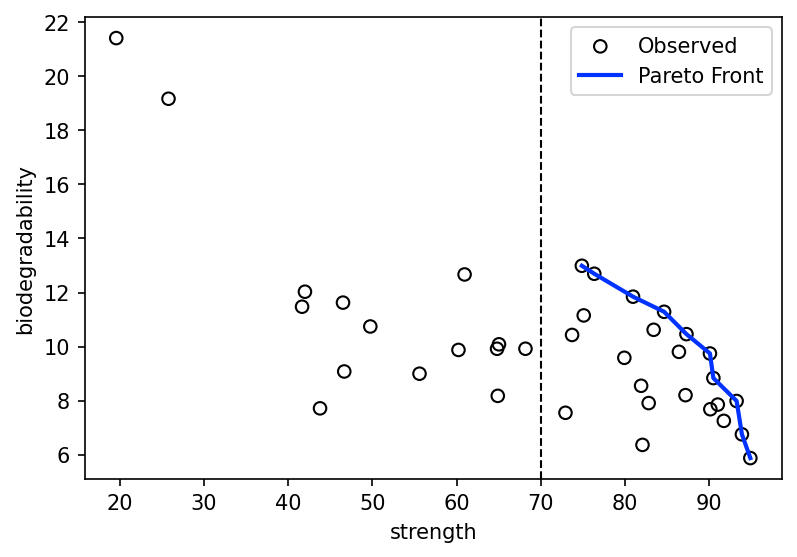

In [3]:
# Plot results
objectives = ax_client.objective_names
df = ax_client.get_trials_data_frame()

fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
pareto = ax_client.get_pareto_optimal_parameters(use_model_predictions=False)
pareto_data = [p[1][0] for p in pareto.values()]
pareto = pd.DataFrame(pareto_data).sort_values(objectives[0])

ax.scatter(df[objectives[0]], df[objectives[1]], fc="None", ec="k", label="Observed")
ax.plot(
    pareto[objectives[0]],
    pareto[objectives[1]],
    color="#0033FF",
    lw=2,
    label="Pareto Front",
)

ax.axvline(70, color="k", ls="--", lw=1) # MOD: add threshold lines

ax.set_xlabel(objectives[0])
ax.set_ylabel(objectives[1])
ax.legend()
plt.show()

## Show the Pareto Optimal Parameters

After the optimization loop has completed, we can view the set of parameter combinations that are found to be Pareto optimal. This will help us understand the tradeoff between the two objectives of interest.

In [4]:
p_op = ax_client.get_pareto_optimal_parameters()

# parse p_op values to get  parameters and values
p_op_index = list(p_op.keys())
p_op_params = [p_op[i][0] for i in p_op_index]
p_op_values = [p_op[i][1][0] for i in p_op_index]

# organize the results into a dataframe
pareto_results = pd.DataFrame(p_op_params, columns=["x1", "x2", "x3", "x4", "x5", "x6", "x7"])
pareto_results["x5"] = total - pareto_results[["x1", "x2", "x3", "x4"]].sum(axis=1)
pareto_results["strength"] = [v["strength"] for v in p_op_values]
pareto_results["biodegradability"] = [v["biodegradability"] for v in p_op_values]
pareto_results.index = p_op_index
display(pareto_results.round(2))

,x1,x2,x3,x4,x5,x6,x7,strength,biodegradability
36,0.00,0.27,0.27,0.10,0.35,0.03,179.07,90.09,9.73
32,0.00,0.35,0.25,0.10,0.30,0.03,195.40,93.24,7.99
25,0.01,0.34,0.30,0.09,0.26,0.02,173.84,90.48,8.85
30,0.00,0.27,0.35,0.10,0.29,0.03,166.18,87.28,10.46
35,0.00,0.20,0.32,0.10,0.38,0.03,166.99,84.63,11.29
31,0.10,0.39,0.25,0.10,0.16,0.03,185.53,93.89,6.75
33,0.11,0.39,0.22,0.10,0.17,0.03,198.70,94.85,5.88
27,0.00,0.22,0.38,0.10,0.29,0.03,153.15,80.93,11.84
28,0.00,0.15,0.42,0.10,0.33,0.03,149.66,76.35,12.70
34,0.00,0.09,0.30,0.10,0.51,0.03,154.66,74.87,12.99


We can also double check to see that the composition constraint was satisifed.

In [5]:
# sum x1 to x5
pareto_results[["x1", "x2", "x3", "x4", "x5"]].sum(axis=1)

36    1.0
32    1.0
25    1.0
30    1.0
35    1.0
31    1.0
33    1.0
27    1.0
28    1.0
34    1.0
dtype: float64

## Next Steps

Interested in taking this further? Try to implement the following on your own!

1. Apply a custom threshold on biodegradability and not how the density of points and the values of the pareto front change in response. Does focussing on a specific region find better points there?

2. Do the results change if you use a different random seed? How much? What does this imply about the consistency of this approach? 